In [1]:
from utils import *
from HeteTrans import *

hete = Heterogeneity()
hete.check_torch_gpu()

-------------------------------------------------
------------------ VERSION INFO -----------------
Conda Environment: Python39 | Python version: 3.9.10 (tags/v3.9.10:f2f3f53, Jan 17 2022, 15:14:21) [MSC v.1929 64 bit (AMD64)]
Torch version: 2.0.0+cu117
Torch build with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080



***
# END

In [52]:
import os, sys, glob, math, re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
from time import time

from cv2 import resize
from scipy.stats import zscore
from scipy.io import loadmat, savemat
from numpy.matlib import repmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchvision.utils import save_image
from torchsummary import summary
from torchviz import make_dot
import torchio as tio

In [86]:
class myDataset(Dataset):
    def __init__(self, data_folder):
        self.y_folder  = data_folder
        self.x_folder  = data_folder+'/X_data'
        self.y_list = [file for file in os.listdir(self.y_folder) if file.endswith('.mat')]
        self.x_list = os.listdir(self.x_folder)

    def __len__(self):
        return len(self.x_list)
    
    def __getitem__(self, idx):
        x_name = self.x_list[idx]
        y_name = self.y_list[idx]

        x_path = os.path.join(self.x_folder, x_name)
        y_path = os.path.join(self.y_folder, y_name)

        x_data = np.load(x_path)
        poro = np.expand_dims(x_data[0],0)
        perm = np.expand_dims(np.log10(x_data[1]),0)
        x = torch.Tensor(np.concatenate([poro,perm],0))

        y = torch.zeros((2,61,256,256))
        y_data = loadmat(y_path, simplify_cells=True)
        for timestep in range(61):
            y[0,timestep] = torch.Tensor(y_data['PRESSURE'])
            y[1,timestep] = torch.Tensor(y_data['SGAS'] * y_data['YMF_3'])

        return x, y

In [87]:
dataset = myDataset(data_folder='h2dataf')
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

for i, (xbatch, ybatch) in enumerate(dataloader):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [97]:
print('X:', xbatch.shape)
print('y:', ybatch.shape)

X: torch.Size([100, 2, 256, 256])
y: torch.Size([100, 2, 61, 256, 256])


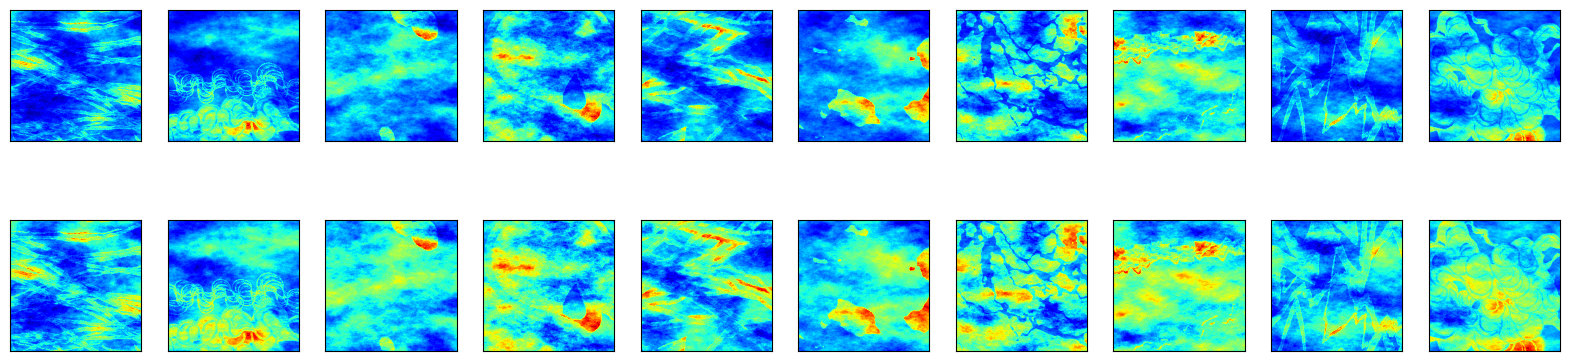

In [92]:
fig, axs = plt.subplots(2, 10, figsize=(20,5))
for i in range(2):
    for j in range(10):
        axs[i,j].imshow(xbatch[j*10,i], 'jet')
        axs[i,j].set(xticks=[], yticks=[])